In [1]:
import os
import json
import re
import math
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from skimage.io import imread, imsave
from skimage.transform import warp
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter, find_peaks
import scipy.stats as stats
from scipy.integrate import odeint, solve_ivp
from numba import njit, prange

In [2]:
#path_ext = '/media/c1046372/Expansion/Thesis GY/3. Analyzed files'
path_ext = '/media/guillermo/Expansion/Thesis GY/3. Analyzed files'
#/Ti scope/2023_11_28/2023_11_28_10x_1.0x_pAAA_Ti_Pos6.ome.tif
#scope_name = 'Tweez scope'
#scope_name = 'Ti scope'
#path_scope = os.path.join(path_ext, scope_name)
#exp_date = '2023_12_08'
#path = os.path.join(path_scope, exp_date)
folder_masks = 'contour_masks'
folder_results = 'results'
folder_fluo = 'fluo'
folder_graphs = 'graphs'
folder_velocity = 'velocity_data'
vectors = ['pAAA', 'pLPT20&41', 'pLPT107&41', 'pLPT119&41']
channels = {'pAAA': {'rfp':0,'yfp':1,'cfp':2,'phase':3},
            'pLPT20&41': {'yfp':0,'cfp':1,'phase':2}, 
            'pLPT119&41': {'yfp':0,'cfp':1,'phase':2},
            'pLPT107&41': {'rfp':0,'yfp':1,'cfp':2,'phase':3}}
scopes = {'Tweez scope': 'TiTweez', 'Ti scope': 'Ti'}
dnas = {'pLPT20&pLPT41': 'pLPT20&41', 'pLPT119&pLPT41': 'pLPT119&41', 'pAAA': 'pAAA', 'pLPT107&pLPT41': 'pLPT107&41'}
vector = 'pLPT20&pLPT41'
if vector == 'pLPT20&pLPT41' or vector == 'pLPT119&pLPT41':
    yfp_chn = 0
    cfp_chn = 1
    ph_chn = 2
    fluo_chns = 2
else:
    rfp_chn = 0
    yfp_chn = 1
    cfp_chn = 2
    ph_chn = 3
    fluo_chns = 3

In [3]:
exp_sum = pd.read_excel('../Notebooks/Exps_summary.xlsx')
exp_sum['formatted_dates'] = exp_sum['Date'].dt.strftime('%Y_%m_%d')
positions = pd.read_excel('../Notebooks/Positions.xlsx')
df = pd.read_excel('data_processed.xlsx')

#### Pull corr velocimetry

In [16]:
y_models = np.array([])
y_datas = np.array([])
for i in exp_sum.index.values:    
    exp_date = exp_sum.loc[i,'formatted_dates']
    vector = exp_sum.loc[i,'DNA']
    scope_name = exp_sum.loc[i,'Machine']
    path_scope = os.path.join(path_ext, scope_name)
    path = os.path.join(path_scope, exp_date)
    
    df_pos = df[(df.Date == exp_sum.loc[i, 'Date']) & 
        (df.DNA == vector) & 
        (df.Machine == scope_name)]
    #poss = df_pos.Position.unique()

    for col in df_pos.index.values:
        if df_pos.loc[col,'r0'] > 1:
            path_results = os.path.join(path, folder_results, f"pos{df_pos.loc[col,'Position']}")
            y_model = np.load(os.path.join(path_results, 'y_model.npy'))
            y_data = np.load(os.path.join(path_results, 'y_data.npy'))
            y_models = np.concatenate((y_models, y_model))
            y_datas = np.concatenate((y_datas, y_data))
        

In [17]:
y_models.shape

(1051851,)

In [18]:
y_datas.shape

(1051851,)

In [19]:
np.corrcoef(y_models,y_datas)

array([[1.        , 0.96008794],
       [0.96008794, 1.        ]])

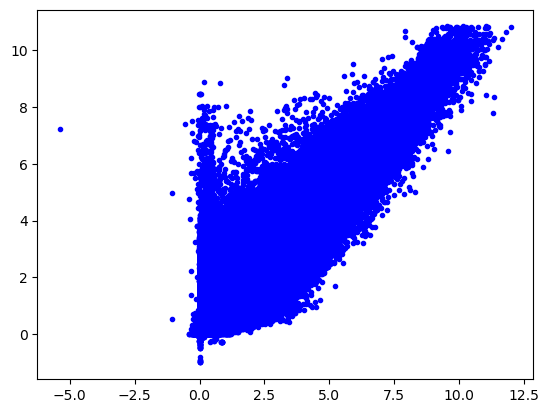

In [20]:
plt.plot(y_datas,y_models, 'b.')
plt.show()

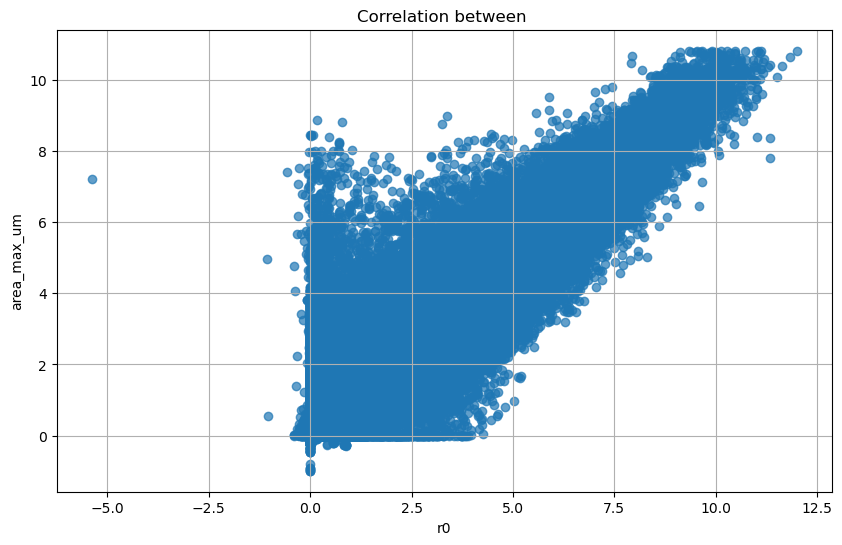

In [10]:
# Plotting with Matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(y_datas, y_models, alpha=0.7)
plt.title('Correlation between ')
plt.xlabel('r0')
plt.ylabel('area_max_um')
plt.grid(True)
plt.show()

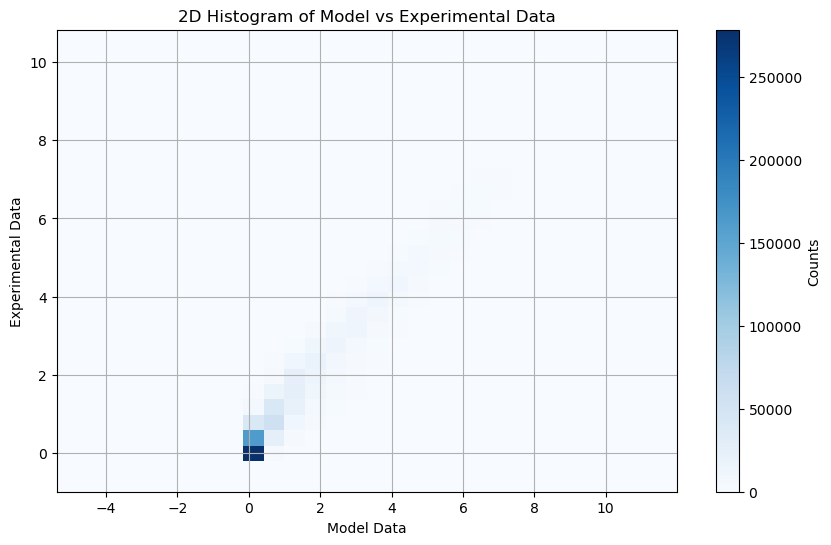

In [15]:
plt.figure(figsize=(10, 6))
plt.hist2d(y_datas, y_models, bins=30, cmap='Blues')
plt.colorbar(label='Counts')
plt.title('2D Histogram of Model vs Experimental Data')
plt.xlabel('Model Data')
plt.ylabel('Experimental Data')
plt.grid(True)
plt.show()

#### Pull r0 and mu0

In [24]:
r0s = np.zeros(len(df))
mu0s = np.zeros((len(df),60))
for i in exp_sum.index.values:    
    exp_date = exp_sum.loc[i,'formatted_dates']
    vector = exp_sum.loc[i,'DNA']
    scope_name = exp_sum.loc[i,'Machine']
    path_scope = os.path.join(path_ext, scope_name)
    path = os.path.join(path_scope, exp_date)
    
    df_pos = df[(df.Date == exp_sum.loc[i, 'Date']) & 
        (df.DNA == vector) & 
        (df.Machine == scope_name)]
    #poss = df_pos.Position.unique()

    for col in df_pos.index.values:
        path_results = os.path.join(path, folder_results, f"pos{df_pos.loc[col,'Position']}")
        r0 = np.load(os.path.join(path_results, 'r0.npy'))
        mu0 = np.load(os.path.join(path_results, 'mu0.npy'))
        r0s[col] = r0
        mu0s[col,:] = mu0

In [67]:
df['r0'] = r0s
df['mu0'] = mu0s

In [ ]:
r0s

In [68]:
df.to_excel('data_processed.xlsx', index=False)

In [69]:
df = pd.read_excel('data_processed.xlsx')
df.head()

,Date,Machine,Position,Strain,DNA,Chemical,Pad,Dilution,t_incub,t_im,...,t_m_logistic,r0,vel_start,vel_stop,vel_fit_start,vel_fit_stop,mu0,ws_params,area_max,area_max_um
0,2023-11-15,Ti scope,0,MC4100,pLPT20&pLPT41,-,1,10^(-5),09:25:00,14:41:00,...,225.219567,19.719626,NaN,NaN,NaN,NaN,0.221419,NaN,81704,106182.5184
1,2023-11-15,Ti scope,1,MC4100,pLPT20&pLPT41,-,1,10^(-5),09:25:00,14:41:00,...,215.629207,32.335440,NaN,NaN,NaN,NaN,0.149091,NaN,117407,152582.1372
2,2023-11-15,Ti scope,3,MC4100,pLPT20&pLPT41,-,1,10^(-5),09:25:00,14:41:00,...,205.356638,42.846932,NaN,NaN,NaN,NaN,0.127281,NaN,108474,140972.8104
3,2023-11-15,Ti scope,6,MC4100,pLPT20&pLPT41,-,1,10^(-5),09:25:00,14:41:00,...,174.692595,20.425528,NaN,NaN,NaN,NaN,0.193441,NaN,79025,102700.8900
4,2023-11-15,Ti scope,7,MC4100,pLPT20&pLPT41,-,1,10^(-5),09:25:00,14:41:00,...,211.573857,27.140298,NaN,NaN,NaN,NaN,-0.020784,NaN,102832,133640.4672


In [41]:
px_tweez = 1.35 
px_ti = 1.14

In [42]:
df.columns

Index(['Date', 'Machine', 'Position', 'Strain', 'DNA', 'Chemical', 'Pad',
       'Dilution', 't_incub', 't_im', 'Quality', 'exp length', 'Colonies',
       'Centers', 'Radius', 'radj', 'radius', 'area', 'gomp_params',
       'logistic_params', 't_m_gomp', 't_m_logistic', 'r0', 'vel_start',
       'vel_stop', 'vel_fit_start', 'vel_fit_stop', 'mu0', 'ws_params',
       'area_max'],
      dtype='object')

In [55]:
area_max_um = np.zeros(len(df))

idx = df[df.Machine == 'Ti scope'].index
area_max_um[idx] = df[df.Machine == 'Ti scope']['area_max']*px_ti**2

idx = df[df.Machine == 'Tweez scope'].index
area_max_um[idx] = df[df.Machine == 'Tweez scope']['area_max']*px_tweez**2

In [56]:
df['area_max_um']=area_max_um

In [57]:
df.to_excel('data_processed.xlsx', index=False)

In [58]:
df.columns

Index(['Date', 'Machine', 'Position', 'Strain', 'DNA', 'Chemical', 'Pad',
       'Dilution', 't_incub', 't_im', 'Quality', 'exp length', 'Colonies',
       'Centers', 'Radius', 'radj', 'radius', 'area', 'gomp_params',
       'logistic_params', 't_m_gomp', 't_m_logistic', 'r0', 'vel_start',
       'vel_stop', 'vel_fit_start', 'vel_fit_stop', 'mu0', 'ws_params',
       'area_max', 'area_max_um'],
      dtype='object')

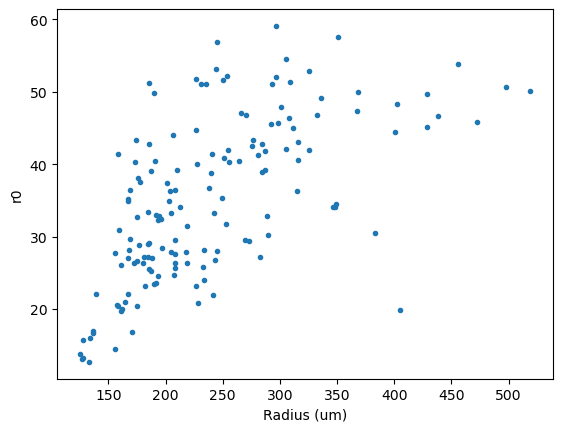

In [85]:
df_r0 = df[df.r0 > 1]
plt.plot(np.sqrt(df_r0['area_max']/np.pi), df_r0['r0'],'.')
plt.ylabel('r0')
plt.xlabel('Radius (um)')
plt.show()

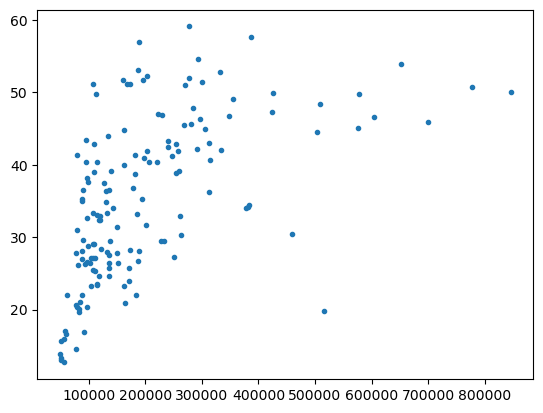

In [84]:
plt.plot(df_r0['area_max'], df_r0['r0'],'.')
plt.show()

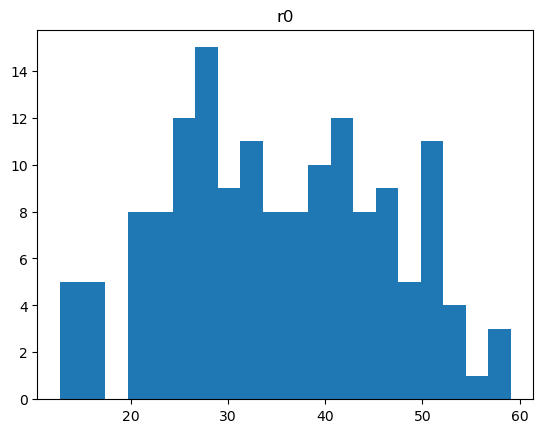

In [81]:
plt.hist(r0s[r0s>1], bins=20)
plt.title('r0')
plt.show()